# Lab Assignment 4, Exercise 2
## Austin Booth

Link:

### Part 1

In [1]:
# add anti-integral windup feature. Already had Kp = 15 and Ki = 1.2 from previous lab, but these may need to be altered

def PI_antiwindup(Kp = 15, Ki = 1.2, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        t_step, SP, PV, MV = yield MV       # <= now gets MV from experiment
        e = PV - SP
        MV += -Kp*(e - e_prev) - t_step*Ki*e 
        MV = max(MV_min, min(MV_max, MV))   # <= range limits
        e_prev = e

In [6]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment_2(controller, t_final=1000, t_step=5,
               SP=lambda t: 30 if t <= 400 else 40):    # sets SP to 30 C at t = 0 s, 40 C at 400 s
    
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 255
        lab.P2 = 50
        next(controller)

        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            U1 = lab.Q1()                            # <==== new line
            U1 = controller.send((t_step, SP(t), T1, U1))    # <==== send U1 to controller 
            lab.Q1(U1)
            p.update(t)    

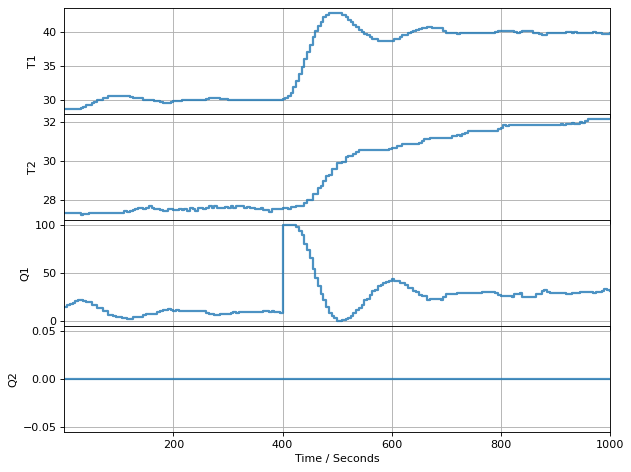

TCLab disconnected successfully.


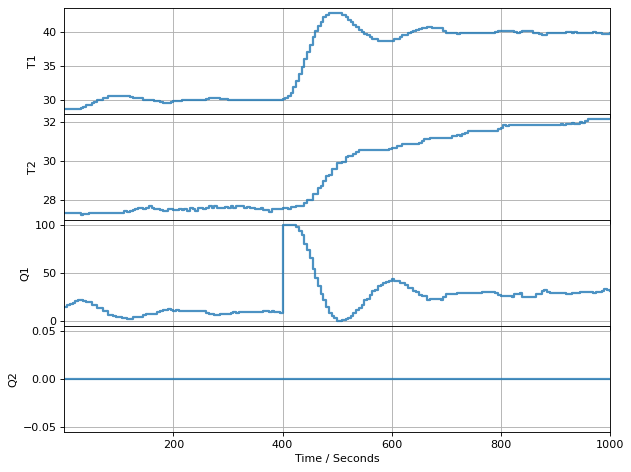

In [11]:
experiment_2(PI_antiwindup(10,0.2))

Assume we want time constant and dead time of T2 with respect to a change in Q1 setpoint.

Then: T1/2 = about 100 seconds, so time constant = 100/0.693 = 144 s.

Dead time = about 50 seconds

K = (32 - 27.5) / (40 - 30) = 0.45 for change in T2 vs. change in SP1

(Instead, if we want tau and t_delay for T1 and Q1:)

(For T1 wrt Q1 SP change: T1/2 = 50 so time constant = 72 s and time delay = about 10 s).

(and K = 1 because the change in T1 is the same as the change in SP)

### Part 3

Using tau = 144, t_delay = 50, and K = 0.45 from previous part:

In [14]:
tau = 144
t_delay = 50
K = 0.45

# calculate Kp using Astrom and Murray
Kp = (0.15*t_delay + 0.35 * tau) / (K * t_delay)   # units 1/K = percent power / degrees C

# calculate Ki using Astrom and Murray
Ki = (0.46*t_delay + 0.02 * tau) / (K * t_delay**2)  # units percent power / deg C * s

print('Kp =',Kp)
print('Ki =',Ki)

Kp = 2.5733333333333333
Ki = 0.023004444444444442


### Part 4

In [15]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment_2(controller, controller2, t_final=500, t_step=5,
               SP=lambda t: 30 if t >= 20 else 0,    # sets SP to 30 C at t = 20 s
               DV=lambda t: 20 if t >= 300 else 0): # sets DV to 20% at t = 300 s
    
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 255
        lab.P2 = 50
        next(controller)

        # event loop
        for t in clock(t_final, t_step):
            T2 = lab.T2
            U1 = lab.Q1()                            # <==== new line
            SP1 = controller.send((t_step,SP(t),T2, U1)) # Outer controller. try to use controller to set SP1 for next step
            U1 = controller2.send((t_step, SP1, T1, U1))    # <==== send U1 to controller. Inner controller
            lab.Q1(U1)
            lab.Q2(DV(t))
            p.update(t)   

In [23]:
def PI_antiwindup(Kp = 10, Ki = 0.2, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        t_step, SP, PV, MV = yield MV       # <= now gets MV from experiment
        e = PV - SP
        MV += -Kp*(e - e_prev) - t_step*Ki*e 
        MV = max(MV_min, min(MV_max, MV))   # <= range limits
        e_prev = e

In [36]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment_2(controller, controller2, t_final=120, t_step=5,
               SP=lambda t: 30 if t >= 20 else 0,    # sets SP to 30 C at t = 20 s
               DV=lambda t: 20 if t >= 300 else 0): # sets DV to 20% at t = 300 s
    
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 255
        lab.P2 = 50
        next(controller)
        next(controller2)

        # event loop
        for t in clock(t_final, t_step):
            T2 = lab.T2
            T1 = lab.T1
            U1 = lab.Q1()                            # <==== new line
            SP1 = controller.send((t_step,SP(t),T2, U1)) # Outer controller. try to use controller to set SP1 for next step
            U1 = controller2.send((t_step, SP1, T1, U1))    # <==== send U1 to controller. Inner controller
            lab.Q1(U1)
            lab.Q2(DV(t))
            p.update(t)   

In [37]:
def newController(Kp = 2.573, Ki = 0.023, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        t_step, SP, PV, MV = yield MV       # <= now gets MV from experiment
        e = PV - SP
        MV += -Kp*(e - e_prev) - t_step*Ki*e 
        MV = max(MV_min, min(MV_max, MV))   # <= range limits
        e_prev = e

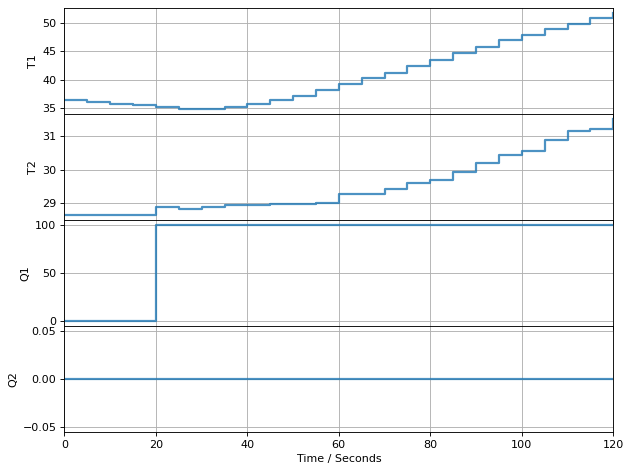

TCLab disconnected successfully.


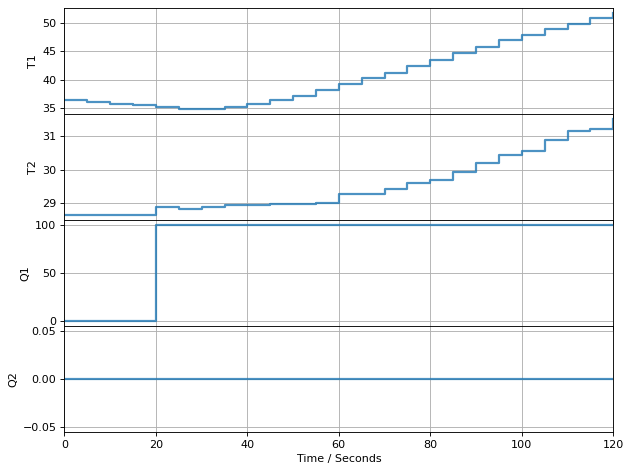

In [38]:
experiment_2(newController(),PI_antiwindup())

Ran out of time to test the function for a longer time, and never figured out how to insert 2 controllers into the same function properly. I apologize.